
## AMPHORA CHALLENGE
### By María José Carbajal Alonso

* Import libraries

In [1]:
import pandas as pd #to manipulate dataframes
import numpy as np #to manipulate matrixes

#these are for google collab
#from google.colab import drive
#drive.mount('/content/drive')

*  We are going to get 2 dataframes, one for the patiens "name" and other for the superpopulation code

In [42]:
#Ancestry file

#ancestry_file = pd.read_csv('drive/MyDrive/Amphora/ancestry-1000genome.tsv', sep='\t')
ancestry_file = pd.read_csv('ancestry-1000genome.tsv', sep='\t')

#Superpopulation code dataframe
spp_code = pd.DataFrame()
spp_code['sample_name'] = ancestry_file['Sample name']

#getting only the patients as a dataframe
patients = spp_code['sample_name']

spp_code['superpopulation_code'] = ancestry_file['Superpopulation code']
#the patient will be set as the index
spp_code.set_index('sample_name', inplace=True)

#getting the 5 categories we will use (ancestry types)
ancestry_types = list(spp_code['superpopulation_code'].unique())

spp_code.head()



,superpopulation_code
sample_name,
NA19625,AFR
NA19835,AFR
NA19900,AFR
NA19917,AFR
NA19703,AFR


* In case we wanted to use a sample of the data, the next cell will help us. 
* Now we are using the 100% of the data, but we can change it with the parameter "frac"

In [5]:
#Using a sample of 100%, random state makes that the sample be the same 

patients_=patients.sample(frac=1, random_state=1)
list(patients_.head(1).values)[0]
print(str(np.array(patients_[:5])))
len(patients_)

['NA20876' 'HG01148' 'HG01366' 'HG01992' 'HG01851']


2504

The main purpose of next cell is to create a DataFrame the merge the data of all the patients including their ancestry

In [6]:
main_df = pd.DataFrame() #empty dataframe where we will save each patient's information
lenn= 10028 #total len = 10028 of chr:location list

for patient in patients_:   

    #Getting the patient's information fron its CSV file
    
    #patient_x = pd.read_csv('drive/MyDrive/Amphora/Challenge_Samples/'+patient+'.csv')
    patient_x = pd.read_csv('Challenge_Samples/'+patient+'.csv')
    patient_x.rename(columns={patient:'Presence'},inplace=True)
    
    #Creating Presence list    
    presence_list = list(patient_x['Presence'])
    presence_list=presence_list[:lenn]

    #Creating a string value that contains all the information of Chr:Location, ALT and Presence
    sequence = ("".join(map(str, presence_list)))

    #Getting the Superpopulation Code 
    code = list(spp_code[spp_code.index==patient]['superpopulation_code'] )
    code = code[0]

    #Getting the values for the three nationalities we're going to predict    
    afr_res = 1  if code == 'AFR' else 0
    eur_res = 1  if code == 'EUR' else 0
    asian_res = 1  if code == 'SAS' or code == 'EAS' else 0

    #creating the data and the columns of the dataframe
    col = ['Patient', 'SPP_code', 'Sequence', 'AFR', 'EUR','ASIAN']
    sample = {'Patient':patient, 'SPP_code':code, 'Sequence':sequence, 'AFR':afr_res, 'EUR': eur_res,'ASIAN':asian_res}    

    df = pd.DataFrame(columns=col)
    df=df.append(sample, ignore_index=True)
    df.set_index('Patient')

    #add the current df to the main_df as a new row
    main_df = pd.concat([main_df,df], axis=0)    

#setting the patient as the index of the dataframe
main_df=main_df.set_index('Patient')

In [8]:
main_df.head()
#main_df.xs('HG01119') #to look according to the index (which is the patient)


,SPP_code,Sequence,AFR,EUR,ASIAN
Patient,,,,,
NA20876,SAS,0000101011011010111011100010000010100011101000...,0,0,1
HG01148,AMR,0110100011011010111010000110000010100010110000...,0,0,0
HG01366,AMR,0011100111011010111011000010000011100000110000...,0,0,0
HG01992,AMR,0110100011111010111011000010001011101001101010...,0,0,0
HG01851,EAS,0001100000011000111011000010000011000101101000...,0,0,1


Let's check how many patients are in each category

In [9]:
print('ASIAN: ',main_df['ASIAN'].sum(),'\n',
'AFRICAN: ',main_df['AFR'].sum(),'\n',
'EUROPEAN: ',main_df['EUR'].sum())

ASIAN:  993 
 AFRICAN:  661 
 EUROPEAN:  503


In [2]:
#Saving the dataframe into a CSV file at Google Drive or locally

"""
For Google Collab
main_df.to_csv('drive/MyDrive/Amphora/main_df_100%_seq.csv', index=True)
df_from_file = pd.read_csv('drive/MyDrive/Amphora/main_df_100%_seq.csv')

"""
#main_df.to_csv('main_df_100%_seq.csv', index=True) #Uncoment this line if you don't have the 'main_df_100%_seq.csv' already
df_from_file = pd.read_csv('main_df_100%_seq.csv')
main_df = df_from_file.set_index('Patient')
main_df.head()

,SPP_code,Sequence,AFR,EUR,ASIAN
Patient,,,,,
NA20876,SAS,0000101011011010111011100010000010100011101000...,0,0,1
HG01148,AMR,0110100011011010111010000110000010100010110000...,0,0,0
HG01366,AMR,0011100111011010111011000010000011100000110000...,0,0,0
HG01992,AMR,0110100011111010111011000010001011101001101010...,0,0,0
HG01851,EAS,0001100000011000111011000010000011000101101000...,0,0,1


##  Here starts the section of training the models

* Import ML libraries

In [159]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import matplotlib.pyplot as plt


* Here there are two functions:
1. **createLabelEncoder()** will encode the sequence of each patient and transform it into a number that we will send to the models as the X value
2. **modelData()** will receive a dataframe and the name of a model and will return the metrics and the confusion matrix of the model selected for those data

In [113]:
#Let's CREATE A FUNCTION to preprocess the data of sequence in order to have an int value to fit the model
from sklearn import preprocessing

def createLabelEncoder(df):

    #creating labelEncoder
    le = preprocessing.LabelEncoder()

    # Converting string labels into numbers.
    seq_encoded=le.fit_transform(df['Sequence'])

    #this is the number in which each sequence was transformed
    #print(set(list(seq_encoded))) 
    #type(seq_encoded)
    #print(list(le.classes_)) #this is the sequence of 0 and 1

    return seq_encoded

    

In [155]:

#function for any model
def modelData(df, modelClass):     

    seq_encoded = createLabelEncoder(df)

    #Declare X and y variables
    x= seq_encoded
    x = x.reshape(-1, 1) 
    y = df[[df.columns[2]]].values

    #train and test data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8,random_state=0)

    
    #Select the correct model according to the atribute received
    if modelClass == 'knn':
        model = KNeighborsClassifier()
        print('MODEL CHOSEN: KNN\n')
    elif modelClass == 'gnb':
        model = GaussianNB()
        print('MODEL CHOSEN: Naive Bayes\n')
    elif modelClass == 'rfc':
        model = RandomForestClassifier()
        print('MODEL CHOSEN: Random Forest\n')
    elif modelClass == 'logreg':
        model = LogisticRegression(solver='liblinear')
        print('MODEL CHOSEN: Logistic Regression\n')
    elif modelClass == 'dtc':
        model = DecisionTreeClassifier()
        print('MODEL CHOSEN: Decision Tree\n')
    elif modelClass == 'svm':
        model = svm.SVC(probability=True)
        print('MODEL CHOSEN: SVM\n')


    #Using cross validation with 10 folds for the model selected        
    cv_scores = cross_val_score(model, X_train,np.ravel(y_train), cv=10,scoring='accuracy').mean()

    #Training the model
    model.fit(X_train, y_train.ravel())

    #Predict the response for test dataset
    y_pred=model.predict(X_test)
 
    #predicted probabilities 
    y_pred_prob=model.predict_proba(X_test)
    #print("Predicted probabilities: ",y_pred_prob[:,1])

    #Print confusion matrix    
    cm = metrics.confusion_matrix(y_test, y_pred)
    # print(cm)
                     
    #----------Plotting
    fig1=plt.figure(figsize=(5,5))
    cmd = metrics.ConfusionMatrixDisplay(cm,display_labels=['Ancestry' ,'Not ancestry'])
    cmd.plot()
    plt.title('Confusion Matrix')
    plt.show()

    fig2=plt.figure(figsize=(5,5))

    fpr, tpr, threshold = metrics.roc_curve(y_test,y_pred_prob[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.subplot(2, 1, 2)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    fig2.suptitle("Figure with only one Subplot")
    plt.show()
      
    #----------End of Plotting 

    
    #Dataframe with the result of the metrics
    return pd.DataFrame(data=[metrics.accuracy_score(y_test, y_pred),
                            cv_scores,
                             metrics.recall_score(y_test, y_pred),
                            metrics.precision_score(y_test, y_pred), 
                            metrics.roc_auc_score(y_test, y_pred_prob[:, 1]),
                            cross_val_score(model, X_train,np.ravel(y_train), cv=10,scoring='roc_auc').mean()], 
                            
                        index=["Accuracy","Cross-val Accuracy", "Recall", "Precision", "AUC score", 'Cross-val AUC']              
                        )
    



### **European ancestry KNN**

MODEL CHOSEN: KNN



<Figure size 360x360 with 0 Axes>

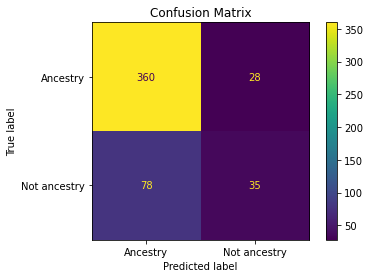

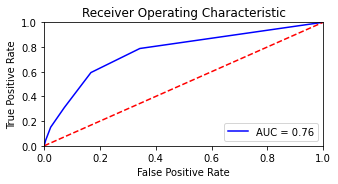

,0
Accuracy,0.788423
Cross-val Accuracy,0.803801
Recall,0.309735
Precision,0.555556
AUC score,0.764574
Cross-val AUC,0.759221


In [156]:
#drop the ancestries we are not going to predict
df_eur = main_df.drop(['ASIAN', 'AFR'], axis=1)

modelData(df_eur, 'knn') # k-nearest neighbor

### **African ancestry Random forest**

MODEL CHOSEN: Random Forest



<Figure size 360x360 with 0 Axes>

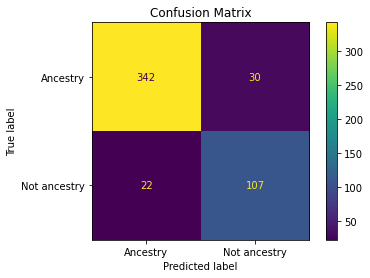

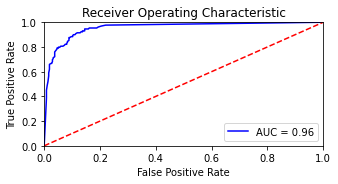

,0
Accuracy,0.896208
Cross-val Accuracy,0.870689
Recall,0.829457
Precision,0.781022
AUC score,0.955155
Cross-val AUC,0.926581


In [157]:
#drop the ancestries we are not going to predict
df_afr = main_df.drop(['EUR', 'ASIAN'], axis=1)

modelData(df_afr, 'rfc') #Random forest


### **Asian ancestry SVM**

MODEL CHOSEN: SVM



<Figure size 360x360 with 0 Axes>

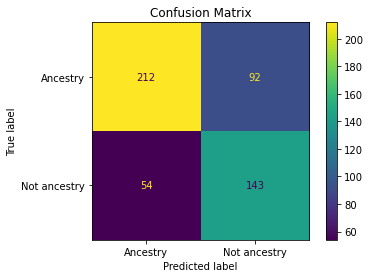

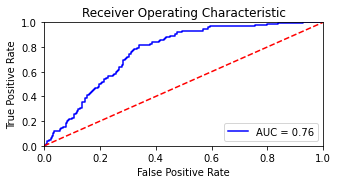

,0
Accuracy,0.708583
Cross-val Accuracy,0.719430
Recall,0.725888
Precision,0.608511
AUC score,0.763742
Cross-val AUC,0.770806


In [158]:
#drop the ancestries we are not going to predict
df_asian = main_df.drop(['AFR', 'EUR'], axis=1)

modelData(df_asian, 'svm') #Support vector machine